
- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

In [102]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
from functions_variables import encode_tags

In [103]:
# load one file first to see what type of data you're dealing with and what attributes it has

directory = '../data/'

with open(f'{directory}AK_Juneau_0.json') as f:
    jsonfile = json.load(f)

testcity = pd.json_normalize(jsonfile['data']['results']).head(3)

jsoncolumns = testcity.columns

testcity

,last_update_date,tags,permalink,status,list_date,open_houses,branding,list_price,property_id,photos,...,location.address.state_code,location.address.line,location.street_view_url,location.county.fips_code,location.county.name,primary_photo,source,products,location.address.coordinate,other_listings
0,2023-09-19T20:52:50Z,"[carport, community_outdoor_space, cul_de_sac,...",9453-Herbert-Pl_Juneau_AK_99801_M90744-30767,sold,2023-06-29T21:16:25.000000Z,None,"[{'name': 'EXP Realty LLC - Southeast Alaska',...",554950.0,9074430767,"[{'tags': [{'label': 'house_view', 'probabilit...",...,AK,9453 Herbert Pl,https://maps.googleapis.com/maps/api/streetvie...,None,Juneau,NaN,NaN,NaN,NaN,NaN
1,None,None,8477-Thunder-Mountain-Rd_Juneau_AK_99801_M9424...,sold,None,None,"[{'name': None, 'photo': None, 'type': 'Office'}]",NaN,9424983842,None,...,AK,8477 Thunder Mountain Rd,https://maps.googleapis.com/maps/api/streetvie...,None,Juneau,NaN,NaN,NaN,NaN,NaN
2,None,None,4515-Glacier-Hwy_Juneau_AK_99801_M94790-68516,sold,None,None,"[{'name': None, 'photo': None, 'type': 'Office'}]",NaN,9479068516,None,...,AK,4515 Glacier Hwy,https://maps.googleapis.com/maps/api/streetvie...,None,Juneau,NaN,NaN,NaN,NaN,NaN


In [104]:
import warnings

df = pd.DataFrame(columns= jsoncolumns)

json_files = [file for file in os.listdir(directory) if file.endswith('.json')]

for file in json_files:
    file_path = os.path.join(directory, file)
    json_subfile = pd.read_json(file_path)
    json_subdf = pd.json_normalize(json_subfile['data']['results'])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = pd.concat([df, json_subdf], ignore_index=True)
    
df.shape

(8191, 67)

In [105]:
[col for col in df.columns if col not in jsoncolumns]

['community.advertisers', 'community.description.name', 'location.county']

At this point, ensure that you have all sales in a dataframe.
- Is each cell one value, or do some cells have lists?
- Maybe the "tags" will help create some features.
- What are the data types of each column?
- Some sales may not actually include the sale price.  These rows should be dropped.
- Some sales don't include the property type.
- There are a lot of None values.  Should these be dropped or replaced with something?

In [106]:
df.shape

(8191, 67)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8191 entries, 0 to 8190
Data columns (total 67 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   last_update_date                       8125 non-null   object 
 1   tags                                   7638 non-null   object 
 2   permalink                              8159 non-null   object 
 3   status                                 8159 non-null   object 
 4   list_date                              7752 non-null   object 
 5   open_houses                            0 non-null      object 
 6   branding                               8159 non-null   object 
 7   list_price                             7721 non-null   object 
 8   property_id                            8159 non-null   object 
 9   photos                                 7403 non-null   object 
 10  community                              0 non-null      object 
 11  virt

In [108]:
df.describe()

,price_reduced_amount,description.year_built,description.baths_3qtr,description.baths_full,description.baths_half,description.lot_sqft,description.sqft,description.baths,description.garage,description.stories,description.beds,location.address.coordinate.lon,location.address.coordinate.lat,location.county
count,2.484000e+03,7316.000000,566.000000,7311.000000,2281.000000,6.991000e+03,7323.000000,7980.000000,4448.000000,6260.000000,7504.000000,7909.000000,7909.000000,0.0
mean,2.442704e+04,1968.916074,1.247350,1.887430,1.105655,2.510949e+05,1933.848559,2.131203,1.926709,1.567732,3.208289,-92.206522,39.009689,NaN
std,7.162396e+04,35.096914,0.463482,0.862214,0.413340,5.823820e+06,1339.039206,1.175940,0.878766,0.730969,1.282732,15.888886,4.374553,NaN
min,1.000000e+02,1828.000000,1.000000,1.000000,1.000000,0.000000e+00,120.000000,0.000000,1.000000,1.000000,0.000000,-157.810583,21.277707,NaN
25%,6.000000e+03,1950.000000,1.000000,1.000000,1.000000,4.953000e+03,1258.000000,1.000000,1.000000,1.000000,3.000000,-104.971611,35.688084,NaN
50%,1.010000e+04,1975.000000,1.000000,2.000000,1.000000,7.841000e+03,1635.000000,2.000000,2.000000,1.000000,3.000000,-89.333131,39.698210,NaN
75%,2.000000e+04,1997.000000,1.000000,2.000000,1.000000,1.263200e+04,2264.000000,3.000000,2.000000,2.000000,4.000000,-78.617690,41.832266,NaN
max,2.015999e+06,2024.000000,3.000000,8.000000,5.000000,1.676624e+08,32106.000000,9.000000,11.000000,10.000000,12.000000,-71.006343,58.396178,NaN


In [109]:
# load and concatenate data here
# drop or replace values as necessary

# print(df.iloc[0,0:10])
# print(df.iloc[0,10:20])
# print(df.iloc[0,20:30])



In [110]:
# print(df.iloc[0,30:40])
# print(df.iloc[0,40:50])
# print(df.iloc[0,50:60])
# print(df.iloc[0,60:70])

In [111]:
print(df['tags'][0])

['central_air', 'dishwasher', 'fireplace', 'forced_air', 'hardwood_floors', 'washer_dryer', 'basement', 'single_story', 'garage_1_or_more', 'garage_2_or_more', 'big_yard', 'vaulted_ceiling', 'open_floor_plan', 'floor_plan', 'corner_lot', 'big_lot', 'ensuite']


In [112]:
print(df['branding'][0])

[{'name': 'Howard Hanna - Colonial Park', 'photo': None, 'type': 'Office'}]


In [113]:
print(df['photos'][0]) 

[{'tags': [{'label': 'garage', 'probability': 0.99981635808945}, {'label': 'house_view', 'probability': 0.99869686365128}, {'label': 'road_view', 'probability': 0.99956554174423}, {'label': 'yard', 'probability': 0.9751615524292}, {'label': 'house_view', 'probability': 0.99909782409668}, {'label': 'house_view', 'probability': 0.99994349479675}], 'href': 'https://ap.rdcpix.com/8c0b391ae4f9bbca36c41d559ef75598l-m2349710986s-w1024_h768.jpg'}]


In [114]:
# [value for value in df['price_reduced_amount'] if value is not np.NaN]


In [115]:

drop_cols = ['last_update_date', 'permalink', 'list_date', 'open_houses', 'branding', 
             'property_id', 'photos', 'community', 'virtual_tours', 'listing_id', 'matterport',
             'primary_photo.href', 'source.plan_id', 'source.agents', 'source.spec_id', 
             'source.type', 'description.name','lead_attributes.show_contact_an_agent',
               'price_reduced_amount', 'flags.is_for_rent', 'flags.is_contingent',
               'flags.is_pending', 'flags.is_plan', 'flags.is_coming_soon', 'flags.is_new_listing',
               'products.brand_name', 'other_listings.rdc', 'location.address.postal_code', 'location.address.line',
               'location.street_view_url', 'location.county.fips_code', 'primary_photo', 'source', 'products',
               'location.address.coordinate', 'other_listings', 'community.advertisers', 'community.description.name',
               'location.county', 'status', 'location.address.state', 'flags.is_new_construction', 
               'flags.is_subdivision', 'flags.is_price_reduced', 'flags.is_foreclosure']

            

df = df.drop(columns= drop_cols)

In [116]:
df.shape

(8191, 22)

In [117]:
# df.iloc[0:5, :10]

In [118]:
# df.iloc[0:5,10:]

In [119]:
# df['flags.is_price_reduced'].value_counts()/df.shape[0]

In [120]:
# df['flags.is_foreclosure'].value_counts()/df.shape[0]

In [121]:
missing_tags = df[df['tags'].isna()]
missing_tags.shape[0]/df.shape[0]

0.06751312416066414

In [122]:
# Extract tags
tags = list({tag for sublist in df['tags'] if isinstance(sublist, list) for tag in sublist})

# Dataframe for tags
tag_df = pd.DataFrame(0, index=df.index, columns=tags)

# Fill in tags
for tag in tags:
    tag_df[tag] = df['tags'].apply(lambda x: 1 if isinstance(x, list) and tag in x else 0)

# Concatenate tag df and original feature set
df = pd.concat([df, tag_df], axis=1)

# Drop the original 'tags' column
df.drop('tags', axis=1, inplace=True)


In [123]:
df = df[~df['description.sold_price'].isna()] # drop missing sell prices

In [124]:
df = df[~df['description.type'].isna()] # drop missing property type
df.shape

(6696, 176)

In [125]:
# original_features = df.iloc[:,0:21] #full feature set is too big for info()
# original_features.info()

In [126]:
df = df.drop(columns=['list_price', 'description.sold_date', 'description.baths_1qtr'])
df = df[~df['description.year_built'].isna()]
df = df[~df['description.lot_sqft'].isna()]
df = df[~df['description.sqft'].isna()]
df = df[~df['location.address.coordinate.lon'].isna()]
df = df[~df['location.address.coordinate.lat'].isna()]

columns_to_fill_zeroes = ['description.baths_3qtr', 'description.baths_full', 'description.baths_half', 'description.baths',
                          'description.garage', 'description.beds']
df[columns_to_fill_zeroes] = df[columns_to_fill_zeroes].fillna(0)

columns_to_fill_NA = ['description.sub_type', 'location.address.city', 'location.county.name']
df[columns_to_fill_NA] = df[columns_to_fill_NA].fillna('N/A')

columns_to_fill_ones = ['description.stories']
df[columns_to_fill_ones] = df[columns_to_fill_ones].fillna(1)


In [127]:
original_features = df.iloc[:,0:18] 
original_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 8190
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   description.year_built           5260 non-null   float64
 1   description.baths_3qtr           5260 non-null   float64
 2   description.sold_price           5260 non-null   object 
 3   description.baths_full           5260 non-null   float64
 4   description.baths_half           5260 non-null   float64
 5   description.lot_sqft             5260 non-null   float64
 6   description.sqft                 5260 non-null   float64
 7   description.baths                5260 non-null   float64
 8   description.sub_type             5260 non-null   object 
 9   description.garage               5260 non-null   float64
 10  description.stories              5260 non-null   float64
 11  description.beds                 5260 non-null   float64
 12  description.type    

In [128]:
df.shape

(5260, 173)

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.
- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE such as using central tendency?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.

In [129]:
# OHE categorical variables here
# tags will have to be done manually

# for column in df.columns[18:]:
#     non_zero_count = df[column].sum()  
#     total_count = len(df)  
#     proportion_non_zero = non_zero_count / total_count  
#     print(f"Column: {column}, Proportion of non-zero values: {proportion_non_zero:.2f}")



In [130]:
columns_to_drop = []

for column in df.columns[18:]:
    non_zero_count = df[column].sum()  
    total_count = len(df)  
    proportion_non_zero = non_zero_count / total_count  
    if proportion_non_zero < 0.05:
        columns_to_drop.append(column)

df.drop(columns_to_drop, axis=1, inplace=True)

print("Columns dropped:")
print(columns_to_drop)

Columns dropped:
['low_hoa', 'river_access', 'master_suite', 'well_water', 'lake_view', 'horse_facilities', 'smart_homes', 'no_hoa', 'cul_de_sac', 'screen_porch', 'volleyball', 'community_tennis_court', 'community_elevator', 'basketball_court', 'fruit_trees', 'medicalcare', 'community_horse_facilities', 'golf_course_lot_or_frontage', 'wine_cellar', 'playground', 'beautiful_backyard', 'soccer', 'river_view', 'mountain_view', 'community_park', 'security', 'gourmet_kitchen', 'spa_or_hot_tub', 'pond', 'solar_panels', 'horse_stables', 'detached_guest_house', 'courtyard_entry', 'pets_allowed', 'community_gym', 'outbuilding', 'rv_parking', 'jack_and_jill_bathroom', 'two_master_suites', 'wooded_land', 'water_view', 'gated_community', 'cathedral_ceiling', 'clubhouse', 'community_center', 'large_porch', 'baseball', 'elevator', 'beach', 'investment_opportunity', 'efficient', 'hill_or_mountain_view', 'tennis', 'rv_or_boat_parking', 'ocean_view', 'community_clubhouse', 'den_or_office', 'indoor_bask

In [131]:
df.shape

(5260, 67)

In [132]:
df['description.type'] = df['description.type'].replace('condo', 'condos')
df = pd.get_dummies(df, columns=['description.type', 'description.sub_type'])

If using numerical values to replace cities or states, make sure that the data is split so that we don't leak data into the training selection.
- If you think about a real scenario, do we have any knowledge of new listings that would come in once modeling is complete?
- Drop columns that aren't needed.
- Don't keep the list price because it will be too close to the sale price.

In [133]:
from sklearn.model_selection import train_test_split

# perform train test split here
train_df, test_df = train_test_split(df, test_size= 0.2, random_state= 42)

# do something with state and city

In [134]:
# Compute means on train_df
city_mean_train = train_df.groupby('location.address.city')['description.sold_price'].transform('mean')
state_mean_train = train_df.groupby('location.address.state_code')['description.sold_price'].transform('mean')
county_mean_train = train_df.groupby('location.county.name')['description.sold_price'].transform('mean')

# Fill means on train_df
train_df['city_mean_sold_price'] = city_mean_train
train_df['state_mean_sold_price'] = state_mean_train
train_df['county_mean_sold_price'] = county_mean_train

# Create DataFrames for means on train_df
city_mean_df = train_df.groupby('location.address.city')['description.sold_price'].mean().reset_index()
city_mean_df.columns = ['location.address.city', 'city_mean_sold_price']
state_mean_df = train_df.groupby('location.address.state_code')['description.sold_price'].mean().reset_index()
state_mean_df.columns = ['location.address.state_code', 'state_mean_sold_price']
county_mean_df = train_df.groupby('location.county.name')['description.sold_price'].mean().reset_index()
county_mean_df.columns = ['location.county.name', 'county_mean_sold_price']

# Set index to corresponding columns for merging
city_mean_df.set_index('location.address.city', inplace=True)
state_mean_df.set_index('location.address.state_code', inplace=True)
county_mean_df.set_index('location.county.name', inplace=True)

# Fill means on test_df
test_df = test_df.merge(city_mean_df, left_on='location.address.city', right_index=True, suffixes=('', '_city_mean'))
test_df = test_df.merge(state_mean_df, left_on='location.address.state_code', right_index=True, suffixes=('', '_state_mean'))
test_df = test_df.merge(county_mean_df, left_on='location.county.name', right_index=True, suffixes=('', '_county_mean'))




In [135]:
train_df.shape

(4208, 78)

In [136]:
test_df.shape

(1048, 78)

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

In [137]:
# perform EDA here

In [138]:
cols_to_int = ['description.year_built', 'description.baths_3qtr', 'description.baths_full', 'description.baths_half',
               'description.lot_sqft', 'description.sqft', 'description.baths', 'description.garage', 'description.stories',
               'description.beds', 'description.sold_price']
train_df[cols_to_int] = train_df[cols_to_int].astype(int)
test_df[cols_to_int] = test_df[cols_to_int].astype(int)


Column: central_air, Proportion: 0.56
Column: garage_3_or_more, Proportion: 0.07
Column: floor_plan, Proportion: 0.13
Column: groundscare, Proportion: 0.06
Column: farm, Proportion: 0.09
Column: carport, Proportion: 0.07
Column: energy_efficient, Proportion: 0.08
Column: dining_room, Proportion: 0.22
Column: fenced_yard, Proportion: 0.17
Column: vaulted_ceiling, Proportion: 0.05
Column: disability_features, Proportion: 0.05
Column: shopping, Proportion: 0.26
Column: garage_1_or_more, Proportion: 0.64
Column: community_swimming_pool, Proportion: 0.08
Column: forced_air, Proportion: 0.45
Column: garage_2_or_more, Proportion: 0.44
Column: community_security_features, Proportion: 0.22
Column: big_yard, Proportion: 0.09
Column: updated_kitchen, Proportion: 0.12
Column: modern_kitchen, Proportion: 0.08
Column: community_outdoor_space, Proportion: 0.52
Column: rental_property, Proportion: 0.1
Column: ranch, Proportion: 0.09
Column: views, Proportion: 0.05
Column: new_roof, Proportion: 0.13
Co

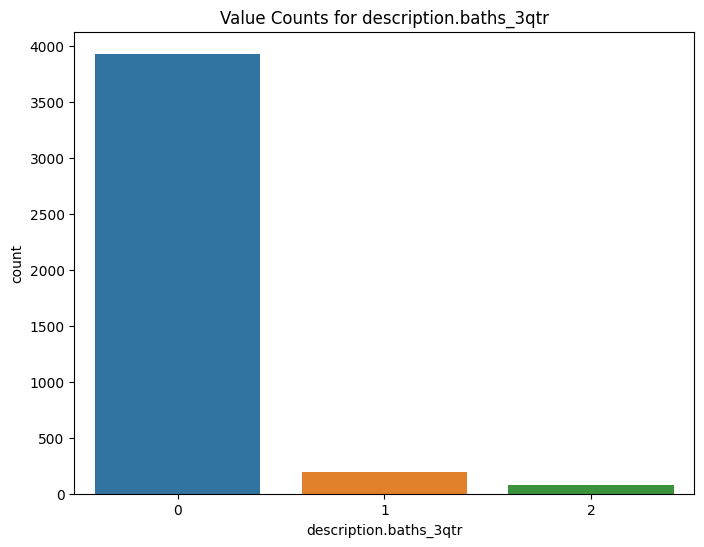

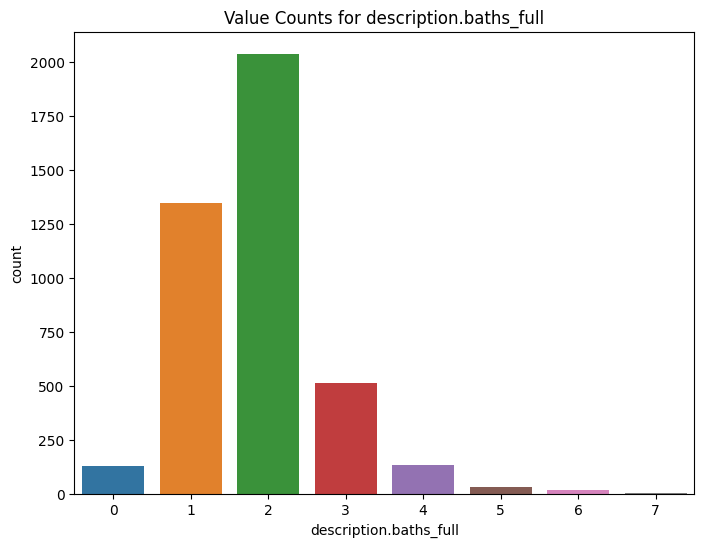

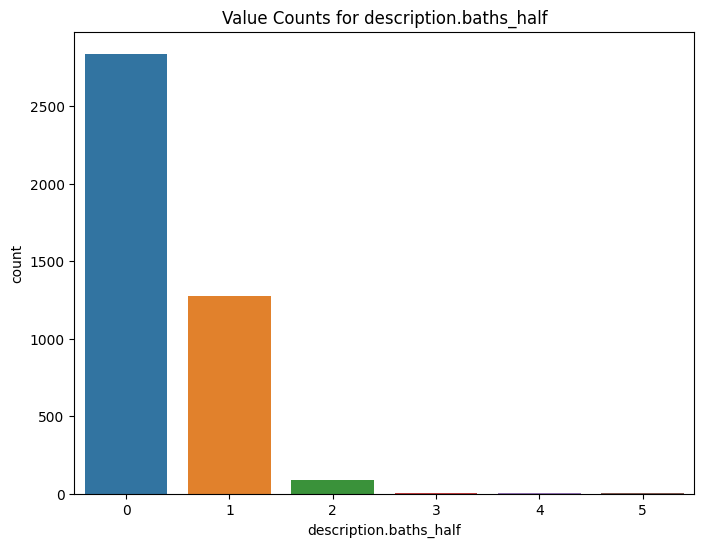

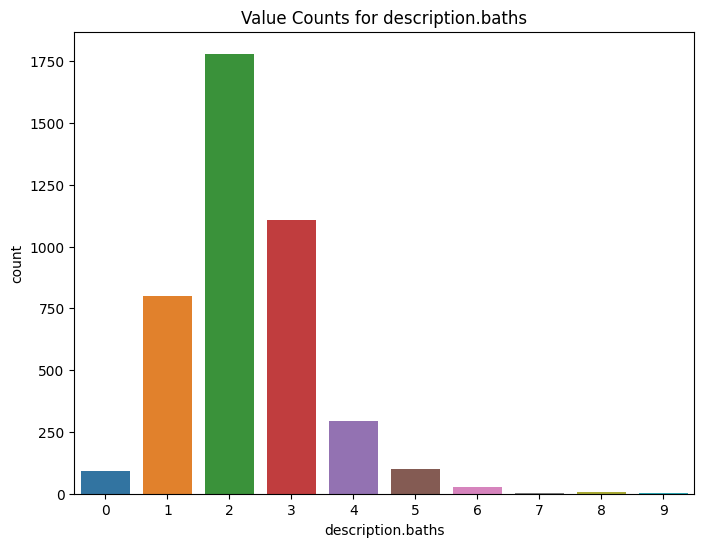

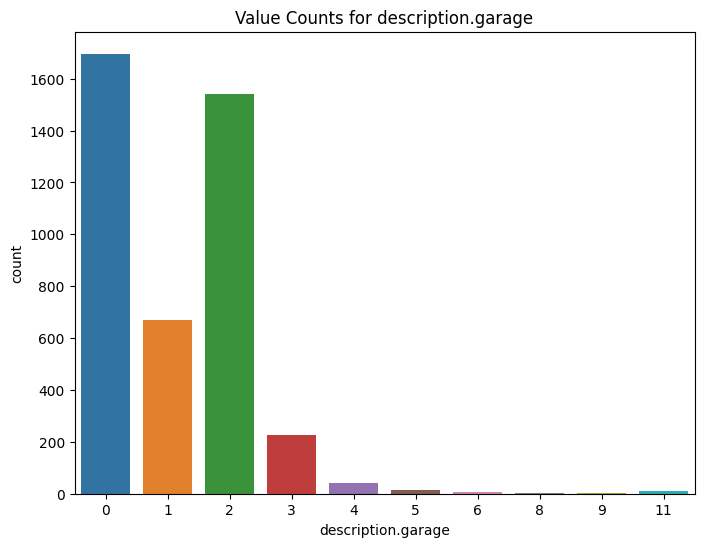

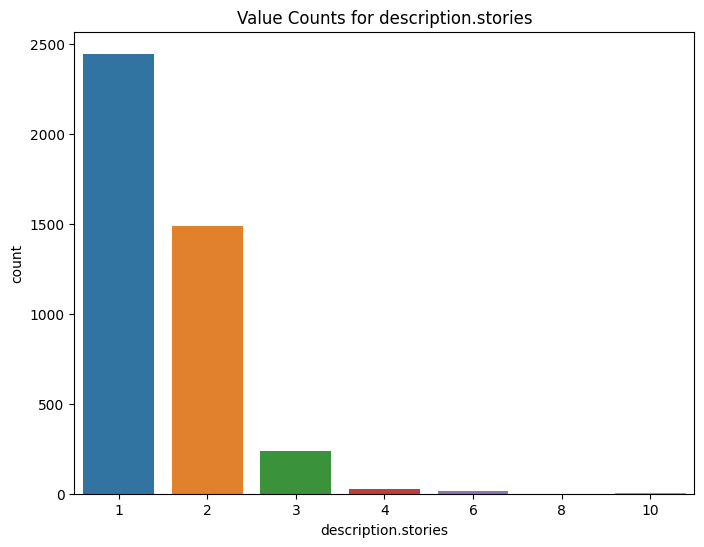

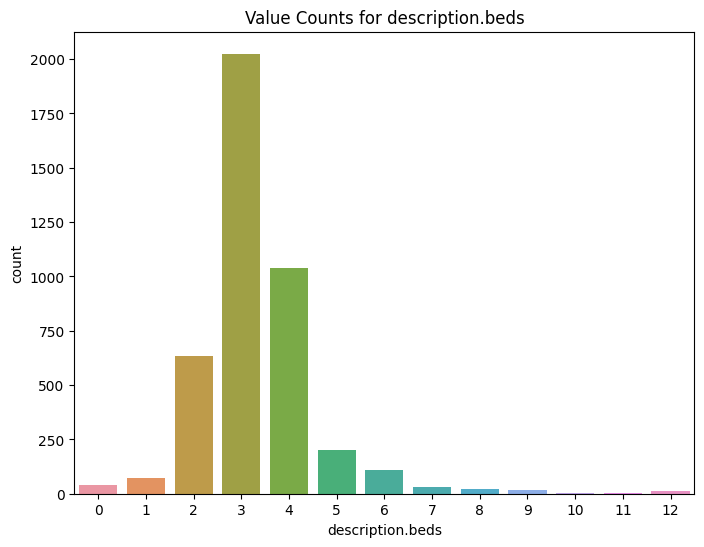

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

int_columns = [col for col in train_df.columns if train_df[col].dtype == int]
hist_columns = ['description.year_built', 'description.sold_price', 'description.lot_sqft', 'description.sqft']
binary_columns = [col for col in int_columns if train_df[col].max() == 1]
int_columns = [col for col in int_columns if col not in hist_columns and col not in binary_columns]
float_cols = [col for col in train_df.columns if train_df[col].dtype == float]
for col in float_cols:
    hist_columns.append(col)

for col in binary_columns:
    print(f"Column: {col}, Proportion: {round(train_df[col].sum()/len(train_df),2)}")

for col in int_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=train_df, x=col)
    plt.title(f'Value Counts for {col}')
    plt.show()

In [141]:
hist_columns

['description.year_built',
 'description.sold_price',
 'description.lot_sqft',
 'description.sqft',
 'location.address.coordinate.lon',
 'location.address.coordinate.lat',
 'city_mean_sold_price',
 'state_mean_sold_price',
 'county_mean_sold_price']

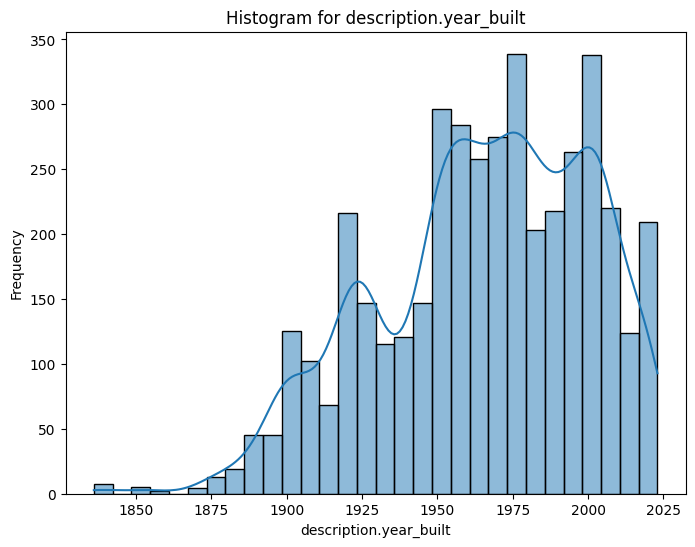

In [142]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='description.year_built', kde=True)
plt.title(f'Histogram for description.year_built')
plt.ylabel('Frequency')
plt.show()

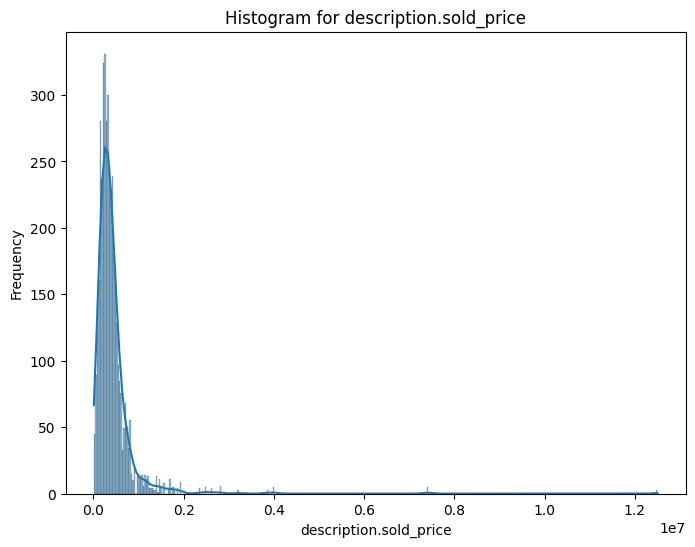

In [143]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='description.sold_price', kde=True)
plt.title(f'Histogram for description.sold_price')
plt.ylabel('Frequency')
plt.show()

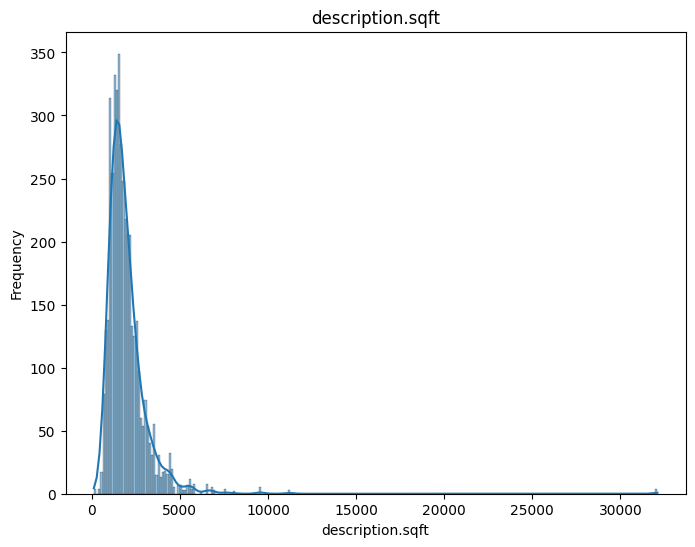

In [144]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='description.sqft', kde=True)
plt.title(f'description.sqft')
plt.ylabel('Frequency')
plt.show()

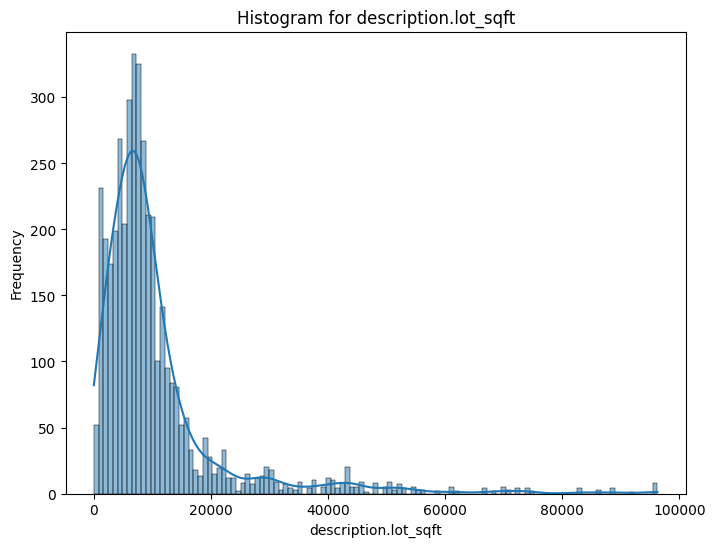

In [145]:
filtered_data = train_df[train_df['description.lot_sqft'] <= 1e5]
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_data, x='description.lot_sqft', kde=True)
plt.title(f'Histogram for description.lot_sqft')
plt.ylabel('Frequency')
plt.show()

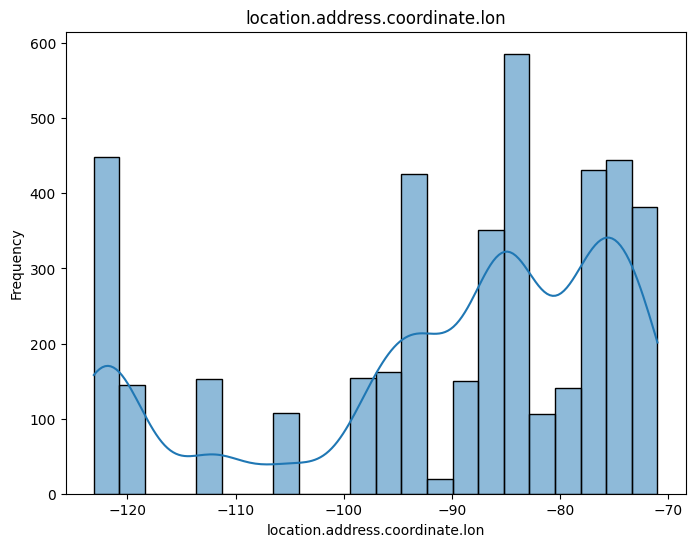

In [146]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='location.address.coordinate.lon', kde=True)
plt.title(f'location.address.coordinate.lon')
plt.ylabel('Frequency')
plt.show()

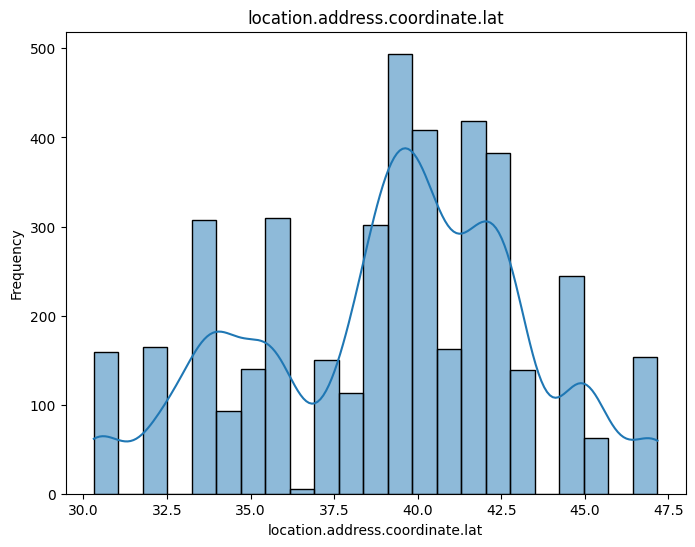

In [147]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='location.address.coordinate.lat', kde=True)
plt.title(f'location.address.coordinate.lat')
plt.ylabel('Frequency')
plt.show()

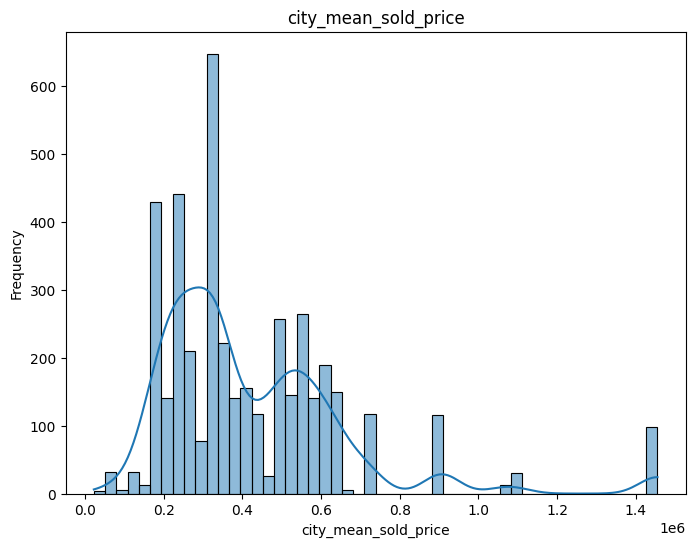

In [148]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='city_mean_sold_price', kde=True, bins = 50)
plt.title(f'city_mean_sold_price')
plt.ylabel('Frequency')
plt.show()

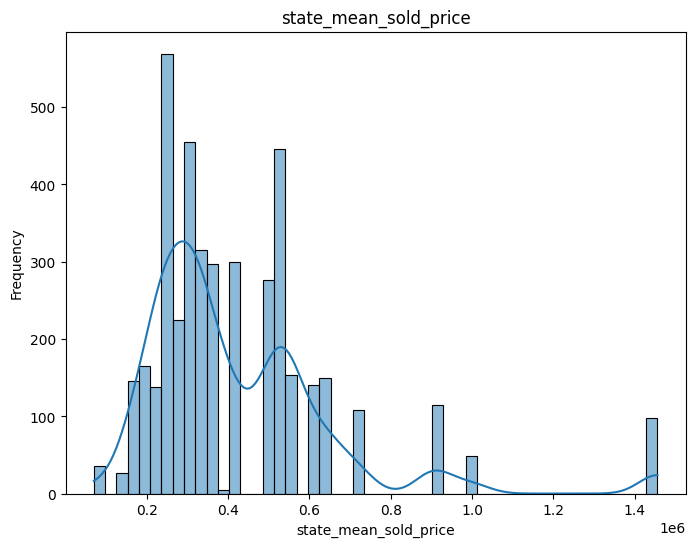

In [149]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='state_mean_sold_price', kde=True, bins = 50)
plt.title(f'state_mean_sold_price')
plt.ylabel('Frequency')
plt.show()

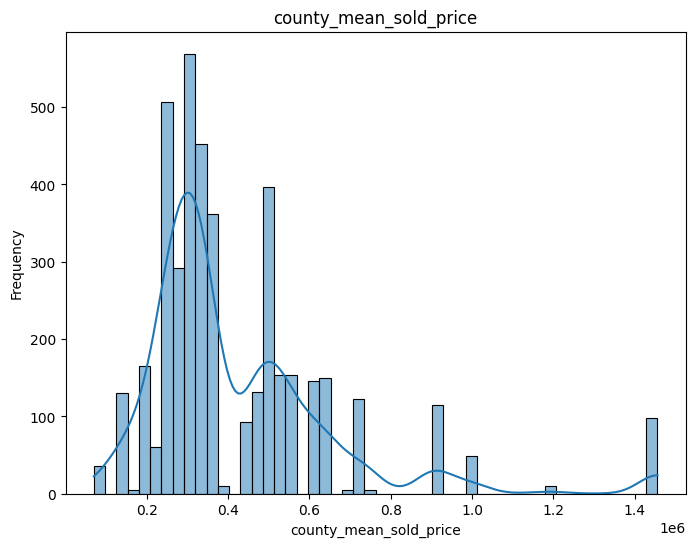

In [150]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_df, x='county_mean_sold_price', kde=True, bins = 50)
plt.title(f'county_mean_sold_price')
plt.ylabel('Frequency')
plt.show()

In [151]:
train_df.columns

Index(['description.year_built', 'description.baths_3qtr',
       'description.sold_price', 'description.baths_full',
       'description.baths_half', 'description.lot_sqft', 'description.sqft',
       'description.baths', 'description.garage', 'description.stories',
       'description.beds', 'location.address.coordinate.lon',
       'location.address.coordinate.lat', 'location.address.city',
       'location.address.state_code', 'location.county.name', 'central_air',
       'garage_3_or_more', 'floor_plan', 'groundscare', 'farm', 'carport',
       'energy_efficient', 'dining_room', 'fenced_yard', 'vaulted_ceiling',
       'disability_features', 'shopping', 'garage_1_or_more',
       'community_swimming_pool', 'forced_air', 'garage_2_or_more',
       'community_security_features', 'big_yard', 'updated_kitchen',
       'modern_kitchen', 'community_outdoor_space', 'rental_property', 'ranch',
       'views', 'new_roof', 'city_view', 'single_story', 'front_porch',
       'high_ceiling', '

In [153]:
dropcols = ['location.address.state_code', 'location.county.name', 'county_mean_sold_price', 'state_mean_sold_price']

In [154]:
train_df, test_df = train_df.drop(columns = dropcols), test_df.drop(columns = dropcols)

Now is a great time to scale the data and save it once it's preprocessed.